# ETF Pipeline2 using s3

> Gradually bringing in over stuff from first pipeline. ETF flow decompositions pipeline but querying data from arcticdb.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# | default_exp etf_pipeline_s3

In [3]:
# | hide
from nbdev.showdoc import *

In [4]:
# | export
import os

import click
from arcticdb import Arctic, QueryBuilder
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from pathlib import Path
from lobster_tools.config import MainConfig, Overrides, register_configs, get_config, NASDAQExchange
from lobster_tools.preprocessing import *
from lobster_tools.querying import *
from lobster_tools.flow_decomposition import *
from lobster_tools.config import etf_to_equities
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from itertools import product
import datetime as dt
from dataclasses import dataclass
from functools import partial
import json
from typing import Literal, cast
import numpy as np
from pprint import pprint
from collections import namedtuple

In [5]:
# | eval: false
register_configs()
cfg = get_config(overrides=Overrides.full_server)

In [6]:
# | eval: false
directory_path = cfg.data_config.csv_files_path
etfs = cfg.universe.etfs
equities = cfg.universe.equities

markouts = cfg.hyperparameters.markouts
finest_resample = cfg.hyperparameters.finest_resample
max_markout = cfg.hyperparameters.max_markout

date_range = dt.date(2021, 1, 6), dt.datetime(2021, 1, 6, 16, 0)

In [7]:
# | eval: false
# temp 
etfs = ['XLC']
equities = etf_to_equities['XLC']
tolerances = ["250us", "500us"]
markouts = ["30S", "1min", "2min", "4min"]
finest_resample = "30S"
max_markout = "4min"
dates = NASDAQExchange().trading_days

### Equity data

In [8]:
# | eval: false
# connect to database
arctic = Arctic('s3://163.1.179.45:9100:lobster?access=minioadmin&secret=minioadmin')
arctic.list_libraries()
arctic_library = arctic["2021"]

In [9]:
# | eval: false
all_symbols = arctic["2021"].list_symbols()
equities = list(set(equities).intersection(all_symbols))

In [10]:
# | eval: false
def get_trading_days(df):
    return df.groupby(df.index.date).first().index

In [11]:
# | eval: false
def read_single_ticker_executions(ticker, date_range = None):
    """Read executions from database for single ticker."""

    columns = [
        "time",
        "event",
        "order_id",
        "size",
        "price",
        "direction",
        "ask_price_1",
        "bid_price_1",
    ]
    q = QueryBuilder()
    q = q[q.event.isin(EventGroup.EXECUTIONS.value)]
    df = arctic_library.read(symbol=ticker, query_builder=q, columns=columns, date_range=date_range).data
    df = df.assign(ticker=ticker, mid= lambda _df: (_df['bid_price_1'] + _df['ask_price_1']) / 2 ).astype({'ticker':'category'})
    return df

In [12]:
# | eval: false
def read_multiple_tickers_executions(tickers, date_range = None):
    """Multiple version of `read_single_ticker_executions`."""
    return pd.concat(
        read_single_ticker_executions(ticker, date_range) for ticker in tickers 
    ).sort_index().astype({"ticker": "category"})

In [13]:
# | eval: false
def date_to_tuple(date: dt.date):
    end_of_trading = dt.time(hour=16)
    return (date, dt.datetime.combine(date, end_of_trading))

def get_datetime_tuples(start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    dates = [x.date() for x in dates]
    date_tuples = [date_to_tuple(x) for x in dates]
    return date_tuples

def timestamp_to_tuple(timestamp):
    end_of_trading_day = pd.Timedelta(hours=16)
    # could also return datetimes with .to_pydatetime
    return (timestamp, timestamp + end_of_trading_day)

def get_timestamp_tuples(start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    date_tuples = [timestamp_to_tuple(x) for x in dates]
    return date_tuples

One day

In [14]:
# | eval: false
def get_mids_for_etf(ticker, date_range):
    """Get only mids at a specified resample frequency."""
    columns = [
        "ask_price_1",
        "bid_price_1",
    ]
    q = QueryBuilder()
    df = arctic_library.read(symbol=ticker, query_builder=q, columns=columns, date_range=date_range).data
    df = df.assign(ticker=ticker, mid= lambda _df: (_df['bid_price_1'] + _df['ask_price_1']) / 2 ).astype({'ticker':'category'})
    resampled_mid = df.mid.resample('30S', label='right', closed='left').last()
    return df, resampled_mid

In [15]:
# | eval: false
def markout_to_int(markout: str, finest_resample: str = "30S"):
    """Maybe add stuff where checks this is almost an int"""
    ratio = pd.Timedelta(markout) / pd.Timedelta(finest_resample)
    if np.isclose(ratio, np.round(ratio), atol=1e-4):
        return int(np.round(ratio))
    else:
        ValueError("Markouts must be multiples of finest resample frequency")

markout_to_int("1min")

2

In [16]:
# | eval: false
def compute_log_returns(mid):
    """Compute mid price dataframe at various markouts and compute log returns for those markouts"""
    df = pd.DataFrame(mid)
    markouts_str = ["30S", "1min", "2min"]

    Markout = namedtuple('Markout', ['str','int'])
    markouts = [Markout(x, markout_to_int(x)) for x in markouts_str]
    for markout in markouts:
        df[f"_{markout.str}"] = df.mid.shift(-markout.int)
    
    df = df.resample('5min', label='right', closed='right').last()

    # not sure how to drop all resampled buckets where there was a NaN before
    # for now simply drop last row of resampled dataframe
    df = df.iloc[:-1]

    # now compute log returns
    markout_columns = df.filter(regex="^_").columns.to_list()
    log_returns = np.log(df[markout_columns].divide(df.mid, axis=0))
    return log_returns

In [17]:
# | eval: false
# note to self - doing closed left when it's `continuous` as unlikely to have exactly on dot
def compute_ofi(df):
    """Compute ofi. Right stamped!"""
    ofi = (
        df[["size", "direction"]]
        .eval("signed_size = size * direction")
        .drop(columns=['direction'])
        .resample(resample_freq, label="right", closed="left")
        .sum()
        .eval('ofi = signed_size / size')
        .ofi
        .fillna(0)
    )
    return ofi
    # ehhh this was annoying. 
    return pd.DataFrame(ofi)

In [18]:
# | eval: false
def run_regressions(X, Y):
    model = MultiOutputRegressor(LinearRegression()).fit(X, Y)

    results = []
    for col, estimator in zip(Y.columns, model.estimators_):
        results.append({
            'target_markout': col,
            'r2': estimator.score(X, Y[col]),
            'coef': estimator.coef_,
            'intercept': estimator.intercept_
        })

    results_df = pd.DataFrame(results).set_index('target_markout')
    return results_df

In [19]:
# | eval: false
# X, Y = restrict_common_index(pd.DataFrame(ofi), log_returns)
# run_regressions(X, Y)

In [20]:
# | eval: false
def compute_neighbor_statistics(etf_executions_neighbors: pd.DataFrame):
    neighbor_statistics = etf_executions_neighbors.filter(regex="^_").notna().sum() / len(etf_executions_neighbors)
    return neighbor_statistics

In [ ]:
# | export
def marginalize(df: pd.DataFrame) -> pd.DataFrame:
    """Quidk implentation just for one feature. Just for _500us!"""
    # TODO think whether inplace is better
    df = df.copy()
    df["_500us_num_trades"] = df._500us_num_trades_os_af + df._500us_num_trades_os_bf + df._500us_num_trades_ss_af + df._500us_num_trades_ss_bf
    # same for others...
    return df

In [21]:
# | eval: false
def sparse_to_dense(df):
    """Convert all sparse columns to dense"""
    sparse_columns = [col for col in df.columns if pd.api.types.is_sparse(df[col].dtype)]
    df[sparse_columns] = df[sparse_columns].sparse.to_dense()
    return df

In [22]:
# | eval: false
def keep_bins(s: pd.Series):
    value_counts = s.value_counts().sort_index()
    CUTOFF = 50
    not_enough_data = value_counts < CUTOFF
    up_to = not_enough_data.idxmax()
    return up_to

In [23]:
# | eval: false
def add_pnl_columns(df):
    df = df.copy(deep=True)
    CLOSE_PRICE = ( df.query("direction == 1").iloc[-1].price + df.query("direction == -1").iloc[-1].price ) / 2
    df = df.assign(pnl_to_close = lambda df_: ( CLOSE_PRICE - df_.price ) / df_.price * 1e4 * df_.direction,
              hit_ratio = lambda df_: ((df_.pnl_to_close) > 0))
    return df

## PoolProcess for many dates

In [24]:
# | eval: false
def dump_to_pickle(date):
    print(etfs)
    print(equities)
    equity_executions=read_multiple_tickers_executions(tickers=equities, date_range=date)
    etf_executions=read_multiple_tickers_executions(tickers=etfs, date_range=date)

    etf_executions_neighbors = add_neighbors(etf_executions=etf_executions, equity_executions=equity_executions, tolerances=tolerances)
    etf_executions_features = append_features(etf_executions=etf_executions_neighbors, equity_executions=equity_executions)
    etf_executions_features_pnl = add_pnl_columns(etf_executions_features)

    # for now just one etf

    # if want to pickle
    # assert len(etfs) == 1
    # etf_name = etfs[0]
    date_str = dt.datetime.combine(date[0], dt.datetime.min.time()).strftime("%Y-%m-%d")
    # etf_executions_features_pnl.to_pickle(f"../features/{etf_name}_{date_str}")
    print(f"done {date_str}")
    return etf_executions_features_pnl

In [25]:
# | eval: false
def filter_to_existing_equities(equities):
    existing_symbols = arctic_library.list_symbols() 
    return list(set(equities).intersection(set(existing_symbols)))

equities = filter_to_existing_equities(equities)
print(equities)

['IPG', 'GOOGL', 'DISH', 'ATVI', 'TTWO', 'VZ', 'GOOG', 'NWS', 'EA', 'OMC', 'NFLX', 'DIS', 'FOX', 'FOXA', 'NWSA', 'CMCSA', 'T', 'TMUS', 'CHTR']


In [27]:
# | eval: false
from concurrent.futures import ProcessPoolExecutor, wait, as_completed
dates = NASDAQExchange().trading_days
dates = dates
dates = [date_to_tuple(x) for x in dates]

with ProcessPoolExecutor(max_workers=70) as executor:
    dfs = list(executor.map(dump_to_pickle, dates))

df = pd.concat(dfs)

['XLC']['XLC']['XLC']['XLC']['XLC']['XLC']['XLC']['XLC']['XLC']['XLC']

['XLC']['XLC']['XLC']
['XLC']
['XLC']['XLC']
['XLC']
['IPG', 'GOOGL', 'DISH', 'ATVI', 'TTWO', 'VZ', 'GOOG', 'NWS', 'EA', 'OMC', 'NFLX', 'DIS', 'FOX', 'FOXA', 'NWSA', 'CMCSA', 'T', 'TMUS', 'CHTR']['IPG', 'GOOGL', 'DISH', 'ATVI', 'TTWO', 'VZ', 'GOOG', 'NWS', 'EA', 'OMC', 'NFLX', 'DIS', 'FOX', 'FOXA', 'NWSA', 'CMCSA', 'T', 'TMUS', 'CHTR']['XLC']['IPG', 'GOOGL', 'DISH', 'ATVI', 'TTWO', 'VZ', 'GOOG', 'NWS', 'EA', 'OMC', 'NFLX', 'DIS', 'FOX', 'FOXA', 'NWSA', 'CMCSA', 'T', 'TMUS', 'CHTR']

['XLC']['XLC']['XLC']['XLC']

['IPG', 'GOOGL', 'DISH', 'ATVI', 'TTWO', 'VZ', 'GOOG', 'NWS', 'EA', 'OMC', 'NFLX', 'DIS', 'FOX', 'FOXA', 'NWSA', 'CMCSA', 'T', 'TMUS', 'CHTR']['XLC']['XLC']['XLC']['XLC']['XLC']['XLC']
['IPG', 'GOOGL', 'DISH', 'ATVI', 'TTWO', 'VZ', 'GOOG', 'NWS', 'EA', 'OMC', 'NFLX', 'DIS', 'FOX', 'FOXA', 'NWSA', 'CMCSA', 'T', 'TMUS', 'CHTR']['IPG', 'GOOGL', 'DISH', 'ATVI', 'TTWO', 'VZ', 'GOOG', 'NWS', 'EA', 'OMC', 'NFLX', 

In [38]:
df.to_pickle("../features/XLC_all")

<Axes: >

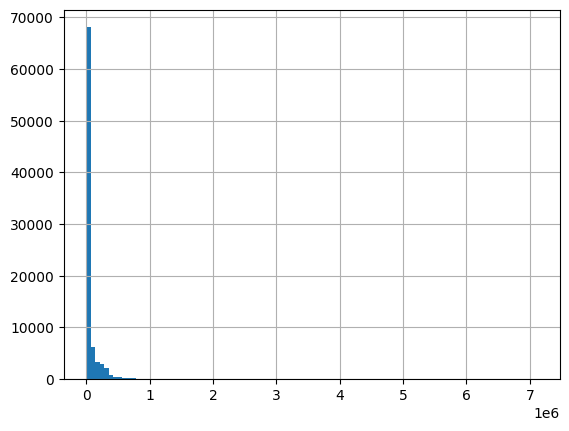

In [31]:
z = df
df.loc[df._500us_notional_os_af > 0, "_500us_notional_os_af"].hist(bins=100)

In [32]:
returns = compute_log_returns(df.mid)
returns

,_30S,_1min,_2min
datetime,,,
2021-01-04 09:35:00,-0.000519,-0.000519,-0.000667
2021-01-04 09:40:00,-0.000519,-0.000445,-0.000519
2021-01-04 09:45:00,-0.000074,-0.000074,-0.000149
2021-01-04 09:50:00,-0.000074,-0.000074,-0.000149
2021-01-04 09:55:00,0.000670,0.000670,0.000596
...,...,...,...
2021-12-31 15:35:00,0.000064,0.000000,-0.000064
2021-12-31 15:40:00,-0.000064,-0.000064,0.000000
2021-12-31 15:45:00,-0.000064,-0.000064,-0.000064


In [33]:
compute_ofi(df)

datetime
2021-01-04 09:35:00   -0.233211
2021-01-04 09:40:00   -0.215316
2021-01-04 09:45:00    0.181602
2021-01-04 09:50:00   -0.032230
2021-01-04 09:55:00    0.489251
                         ...   
2021-12-31 15:40:00   -0.351283
2021-12-31 15:45:00   -0.159085
2021-12-31 15:50:00   -0.175439
2021-12-31 15:55:00    0.090304
2021-12-31 16:00:00    0.056551
Freq: 5T, Name: ofi, Length: 104046, dtype: float64

In [35]:
Y.fillna

pandas.core.frame.DataFrame

In [36]:
X = compute_ofi(df)
Y = compute_log_returns(df.mid)
Y = Y.fillna(0)
X, Y = restrict_common_index(X, Y)

run_regressions(X,Y)

ValueError: Expected 2D array, got 1D array instead:
array=[-0.23321091 -0.21531612  0.18160167 ... -0.1590851  -0.17543905
  0.0903039 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Load with ArcticDB

In [ ]:
# | eval: false
closing_prices = df.resample('D').transform('last').price

In [ ]:
# | eval: false
df["closing_price"] = closing_prices

In [ ]:
# | eval: false
df.eval("pnl_to_close = (closing_price - price) * 1e4 * direction", inplace=True)
df.eval("hit_ratio = (pnl_to_close > 0)", inplace=True)

In [ ]:
# | eval: false
summary_statistics = df.groupby(by="_500us_num_trades").agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))

In [ ]:
# | eval: false
import matplotlib.pyplot as plt
for col in summary_statistics:
    summary_statistics[col].plot(title=col, kind="bar")
    plt.show()

In [ ]:
# | eval: false
%store etf_executions_neighbors
%store etf_executions_features

In [ ]:
# etf_executions_features = marginalise(etf_executions_features, over='same_sign/opposite_sign')

In [ ]:
# etf_executions_features.columns

In [ ]:
# etf_executions_features["_500us_num_trades"] = etf_executions_features._500us_num_trades_os_af + etf_executions_features._500us_num_trades_os_bf + etf_executions_features._500us_num_trades_ss_af + etf_executions_features._500us_num_trades_ss_bf

In [ ]:
# etf_execution_features.filter(regex="^_").hist()

In [ ]:
# easy way without query builder
# date_range = [datetime.date(year=2020, month=1, day=2), datetime.date(year=2020, month=1, day=3)]
# df = library.read(ticker, date_range=date_range).data

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()